Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Manuela Bastidas Olivares y Nicolás Guarín-Zapata 2024.

# Método de colocación con PyTorch

En este notebook se implementa el método de colocación
minimizando el error cuadrático medio del residual
en los puntos de colocación.

Adicionalmente, se hace uso de la diferenciación automática
para calcular el residual.

In [1]:
# # Esto permite tener gráficos interactivos en
# # el caso de correrse en Google Colab
# if 'google.colab' in str(get_ipython()):
#     %pip install ipympl
#     from google.colab import output
#     output.enable_custom_widget_manager()

In [2]:
#%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad

In [4]:
# if 'google.colab' in str(get_ipython()):
#     style = "https://raw.githubusercontent.com/nicoguaro/pinns_mapi-3/main/notebooks/clean.mplstyle"
# else:
#     style = "./clean.mplstyle"
# plt.style.use(style)

## Problema a resolver

Queremos resolver la siguiente ecuación diferencial

$$\frac{d^2u}{dx^2} + u + x = 0 \enspace , $$

con condiciones de frontera $u(0)=u(1)=0$, que tiene
como solución exacta

$$u_e(x) = \frac{\sin(x)}{\sin(1)} - x \, .$$

## Función de aproximación propuesta

En este caso, hacemos uso de una función de aproximación
polinómica

$$u_N(x) = \sum_{i=0}^N c_i \phi_i(x) = x (1-x) \sum_{i=0}^N c_i x^i\, ,$$

en donde vemos que esta función satisface las condiciones de frontera.

In [5]:
def funcion_aprox(x, c):
    """Función de aproximación con coeficientes c y variable x"""
    terms = [coef * x**(i + 1) * (1 - x) for i, coef in enumerate(c)]
    return torch.sum(torch.stack(terms), dim=0)


Y el residual estaría dado por

$$R = \frac{d^2 u_N}{dx^2} + u_N + x\, .$$


## Uso de diferenciación automática

En lugar de calcular el residuo análiticamente se obtiene con diferenciación automática.

In [6]:
# Derivada
def derivative(dy, x, order=1):
    for _ in range(order):
        dy = grad(dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]
    return dy

# Residuo
def residuo(x, c):
    return derivative(funcion_aprox(x, c), x, order=2) + funcion_aprox(x, c) + x

# Función de pérdida: error cuadrático medio
def loss_fn(x, c):
    res = residuo(x, c)
    return torch.mean(res ** 2) 


# Inicialización de coeficientes de forma aleatoria
def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n) * std_dev

In [30]:
npts = 20
x_coloc = torch.tensor([(cont + 1)/(npts + 1) for cont in range(npts+1)],
                       requires_grad=True)

c = initialize_coefficients(npts).requires_grad_(True)

In [31]:
# Configuración del optimizador
optimizer = torch.optim.Adam([c], lr=0.01)

# Bucle de entrenamiento
num_epochs = 10_000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Limpiar gradientes previos
    current_loss = loss_fn(x_coloc, c)  # Calcular la pérdida
    losses.append(current_loss.item())
    current_loss.backward()  # Calcular gradientes
    optimizer.step()  # Actualizar parámetros

    if epoch % 100 == 0:  # Mostrar progreso cada 1000 épocas
        print(f'Epoch {epoch}, Loss: {current_loss.item():g}')

# Resultados optimizados
print(f'Optimized c: {c.data}') 

Epoch 0, Loss: 5.62728
Epoch 100, Loss: 0.00805047
Epoch 200, Loss: 0.00225822
Epoch 300, Loss: 0.00061116
Epoch 400, Loss: 0.000269871
Epoch 500, Loss: 0.000171685
Epoch 600, Loss: 0.000113678
Epoch 700, Loss: 7.24989e-05
Epoch 800, Loss: 4.42553e-05
Epoch 900, Loss: 2.59303e-05
Epoch 1000, Loss: 1.46813e-05
Epoch 1100, Loss: 8.14091e-06
Epoch 1200, Loss: 4.53581e-06
Epoch 1300, Loss: 2.64848e-06
Epoch 1400, Loss: 1.70527e-06
Epoch 1500, Loss: 1.24951e-06
Epoch 1600, Loss: 1.03044e-06
Epoch 1700, Loss: 9.19379e-07
Epoch 1800, Loss: 8.54904e-07
Epoch 1900, Loss: 8.09912e-07
Epoch 2000, Loss: 7.73029e-07
Epoch 2100, Loss: 7.40101e-07
Epoch 2200, Loss: 7.09604e-07
Epoch 2300, Loss: 6.81034e-07
Epoch 2400, Loss: 6.5431e-07
Epoch 2500, Loss: 6.29343e-07
Epoch 2600, Loss: 6.06048e-07
Epoch 2700, Loss: 5.84452e-07
Epoch 2800, Loss: 5.66262e-07
Epoch 2900, Loss: 6.69941e-06
Epoch 3000, Loss: 5.32168e-07
Epoch 3100, Loss: 5.16407e-07
Epoch 3200, Loss: 0.000700462
Epoch 3300, Loss: 4.99451e-07


Gráfica de la predicción obtenida.

In [36]:
x = torch.linspace(0, 1, steps=100)
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x

Text(0, 0.5, 'u(x)')

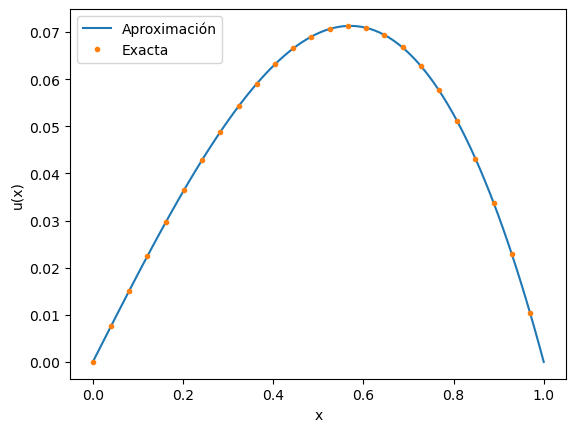

In [37]:
fig = plt.figure()
plt.plot(x, y_pred)
plt.plot(x, y_true, ".", markevery=4)
plt.legend(['Aproximación', 'Exacta'])
plt.xlabel("x")
plt.ylabel("u(x)")

Gráfica el residuo obtenido luego de la optimización.

ValueError: x and y must have same first dimension, but have shapes (21,) and (20,)

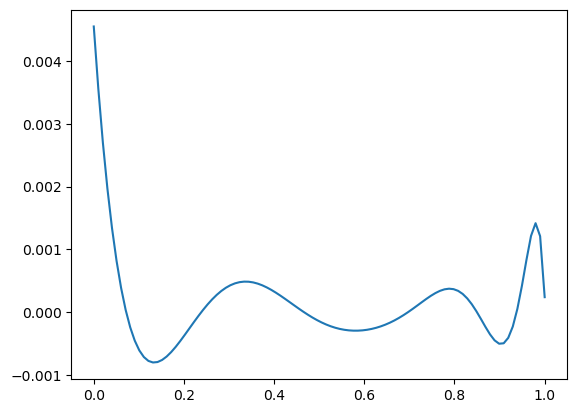

In [38]:
x.requires_grad_(True)

fig = plt.figure()
plt.plot(x.detach().numpy(), residuo(x, c).detach().numpy())
plt.plot(x_coloc.detach().numpy(), [0]*npts, ".")
plt.xlabel("x")


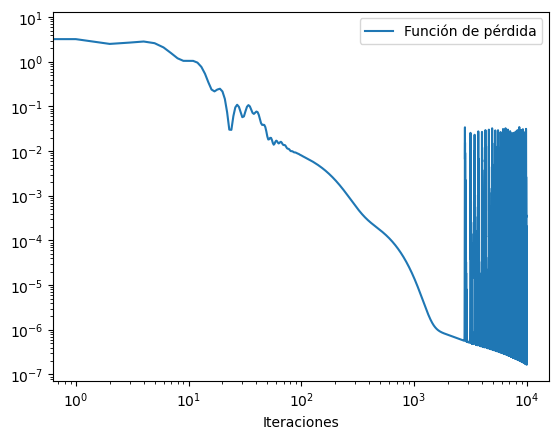

In [35]:
fig, ax = plt.subplots()
plt.loglog(losses)
plt.xlabel("Iteraciones")
plt.legend(['Función de pérdida'])